# Briana Nguyen - MAT SCI 199 Reserch

## Functions

XSpectra input arguments documentation:
- pw.x input arguments: https://www.quantum-espresso.org/Doc/INPUT_PW.html 
- xspectra.x input arguments: https://gitlab.com/QEF/q-e/blob/master/XSpectra/Doc/INPUT_XSPECTRA 

### Helper functions

In [ ]:
from striprtf.striprtf import rtf_to_text
import re
import matplotlib.pyplot as plt
import numpy as np

In [29]:
def get_atomic_mass(element):

    # description: obtain atomic mass of given element 

    # arguments
    ## element: string abbreviation of element
    
    atomic_masses = {
        "H": 1.008, "He": 4.0026, "Li": 6.94, "Be": 9.0122, "B": 10.81, "C": 12.011, 
        "N": 14.007, "O": 15.999, "F": 18.998, "Ne": 20.180, "Na": 22.990, "Mg": 24.305,
        "Al": 26.982, "Si": 28.085, "P": 30.974, "S": 32.06, "Cl": 35.45, "Ar": 39.948,
        "K": 39.098, "Ca": 40.078, "Sc": 44.956, "Ti": 47.867, "V": 50.942, "Cr": 51.996,
        "Mn": 54.938, "Fe": 55.845, "Co": 58.933, "Ni": 58.693, "Cu": 63.546, "Zn": 65.38
        # Add more elements as needed
    }
    return atomic_masses.get(element, "Invalid element")

In [ ]:
# test case
get_atomic_mass("C")

12.011

In [30]:
def get_atom_type(atom_index, atom_types, atom_counts):

    # description: obtains the atom type for a specific index in a VASP file 

    # arguments
    ## atom_index: index of target atom, numeric
    ## atom_types: list of atom types in VASP file, string
    ## atom_counts: list of atom counts per atom type in VASP file, string

    cumulative_count = 0  # Tracks the total number of atoms processed

    for i, count in enumerate(atom_counts):
        if atom_index < cumulative_count + count:
            return atom_types[i]  # found the correct element
        cumulative_count += count  # move to the next element group

    return None

In [ ]:
# test case
atom_types = ["C", "H", "O"]
atom_counts = [1, 2, 4]
for i in range(sum(atom_counts)):
    print(get_atom_type(i, atom_types, atom_counts))

C
H
H
O
O
O
O


### Convert VASP to pw.x input file

In [ ]:
# pw.x INPUT 
# can add more arguments and allow adjustments of values with defaults set 

def scf_input(vasp_file, prefix, pseudofile_list, absorbing_atom_type, absorbing_atom_index, 
               ecutwfc = 30, pseudo_directory = '$PSEUDO_DIR/', out_directory = '$TMP_DIR/'):
    
    # description: converts VASP file into input for SCF calculations using pw.x for XANES
    # Notes: 
    ## VASP file must contain the following data: scaling factor, unscaled lattice vectors, 
    ## species names, ions per species and ion positions
    ## This function will work if also given more than one atom specie

    # arguments
    ## vasp_file: path to VASP file, string
    ## prefix: name of material, string
    ## pseudofile_list: list of pseudofiles, strings 
    ## absorbing_atom_type: the type of absorbing atom, string 
    ## absorbing_atom_index: the index of the absorbing atom in the coordinates beginning at 0, numeric
    ## ecutwfc: defines maximum kinetic energy cutoff for plane waves, numeric  
    ## pseudo_directory: location of pseudopotential, string
    ## out_directory: location of where to place output files from scf calculation, string

    lattice_vectors = ""
    coordinates = ""
    atom_types = []
    atom_counts = []
    atom_species = ""

    with open(vasp_file, "r") as file: 
        line_number = 1
        for line in file:
            values = line.split() 

            try: 
                n_values = list(map(float, values))
            except: 
                n_values = []

            if line_number == 2: # obtain scaling factor(s)
                scaling_factors = n_values
            elif line_number > 2 and line_number < 6: # store scaled lattice vectors 
                if len(scaling_factors) == 1: 
                    scaled_values = [v * scaling_factors[0] for v in n_values]
                else:
                    scaled_values = [n_values[i] * scaling_factors[i] for i in range(3)]
                lattice_vectors += f"{' '.join(map(str, scaled_values))}\n"
            elif line_number == 6: # obtain atom types and number of each atom type
                atom_types = values
                number_atom_types = f"{len(values) + 1}"
            elif line_number == 7: # obtain total number of atoms in the system
                atom_counts = list(map(int, values))
                number_atoms = f"{sum(n_values)}"
            elif line_number == 8: # determine coordinate type
                if values[0] == "Direct":
                    position_type = "crystal"
                else:
                    position_type = "angstrom"
            elif line_number > 8: # store atomic position coordinates in proper format
                atom_number = line_number - 9
                atom = get_atom_type(atom_number, atom_types, atom_counts)

                # label the correct absorbing atom 
                if atom_number == absorbing_atom_index:
                    if atom == absorbing_atom_type:
                        atom = atom + '_h'
                    else:
                        raise ValueError("Invalid index for absorbing atom.")

                if position_type == "angstrom":
                    if len(scaling_factors) == 1: # scale coordinates 
                        scaled_values = [v * scaling_factors[0] for v in n_values]
                    else:
                        scaled_values = [n_values[i] * scaling_factors[i] for i in range(3)]
                    coordinates += f"{atom} {' '.join(map(str, scaled_values))}\n"
                else:   
                    coordinates += f"{atom} {' '.join(map(str, n_values))}\n"
            line_number +=1
            
        # check if valid index for absorbing atom 
        if (line_number - 10) < absorbing_atom_index:
            raise ValueError("Invalid index for absorbing atom.")

    # match pseudofiles to atom type
    pseudo_dict = dict(zip(atom_types, pseudofile_list))

    # create atomic species with atom type, atomic mass and pseudofiles 
    for index, atom in enumerate(atom_types):
        atomic_mass = get_atomic_mass(atom)
        atom_pseudofile = pseudo_dict[atom]
        atom_species += atom + f" {atomic_mass} " + atom_pseudofile + "\n"

    atom_species += absorbing_atom_type + '_h' + f" {get_atomic_mass(absorbing_atom_type)} " + pseudo_dict[absorbing_atom_type] + "\n"
    
    control = " &control\n    calculation='scf',\n    pseudo_dir='" + pseudo_directory + "',\n    outdir='" + out_directory + "',\n    prefix='" + prefix + "',\n /\n"
    system = " &system\n    ibrav=0,\n    nat=" + number_atoms + ",\n    ntyp=" + number_atom_types + ",\n    ecutwfc=" + f"{ecutwfc}" + ",\n /\n" 
    electrons = " &electrons\n /\n"
    atomic_species = "ATOMIC_SPECIES\n" + atom_species 
    atomic_positions = "ATOMIC_POSITIONS " + position_type +"\n" + coordinates 
    k_points = "K_POINTS gamma\n"
    cell_parameters = "CELL_PARAMETERS angstrom\n" + lattice_vectors
    
    scf_input = control + system + electrons + atomic_species + atomic_positions + k_points + cell_parameters

    output_file = prefix + ".scf.in"
    
    with open(output_file, 'w') as file:
        file.write(scf_input)

In [ ]:
# test case 
scf_input("/Users/briannanguyen/Desktop/d0.0_11.vasp", "amorphousC", ["C.UPF"], absorbing_atom_type='C', absorbing_atom_index=1)
with open("/Users/briannanguyen/Desktop/amorphousC.scf.in", "r") as file:
    print(file.read())

 &control
    calculation='scf',
    pseudo_dir='$PSEUDO_DIR/',
    outdir='$TMP_DIR/',
    prefix='amorphousC',
 /
 &system
    ibrav=0,
    nat=216.0,
    ntyp=2,
    ecutwfc=30,
 /
 &electrons
 /
ATOMIC_SPECIES
C 12.011 C.UPF
C_h 12.011 C.UPF
ATOMIC_POSITIONS crystal
C 0.920046985 0.538343012 0.798123002
C_h 0.171909004 0.143947005 0.122047998
C 0.0813317 0.051147498 0.129130006
C 0.148716003 0.22811 0.210502997
C 0.153945997 0.183634996 0.00468727
C 0.429477006 0.228919998 0.048110899
C 0.302736998 0.102904998 0.129656002
C 0.417299002 0.181005001 0.175882995
C 0.492424011 0.069002502 0.199781999
C 0.350356013 0.128628999 0.00471306
C 0.040369701 0.0579025 0.396081001
C 0.111681998 0.178266004 0.412741005
C 0.204706997 0.181998998 0.329005003
C 0.239895001 0.0516048 0.317636013
C 0.440883011 0.114155002 0.463212997
C 0.154223993 0.194620997 0.535198987
C 0.172016993 0.082363799 0.585200012
C 0.146504998 0.024703201 0.695822001
C 0.0133889 0.047878299 0.738969982
C 0.385540009 0.163

### convert pw.x to xspectra.x input file

In [10]:
# xspectra.x INPUT 
# can add more arguments and allow adjustments of values with defaults set 

def xspectra_input(cwf_file, prefix, out_directory = '$TMP_DIR/', absorbing_atom_index = 1, kpoints = '1 1 1 0 0 0', edge = 'K', 
                   xnepoint = 100, xemax = 10, xemin = 0, cut_occ_states = '.false.'):
    
    # description: create xspectra.x input file from calculated SCF data

    # arguments
    ## cwf_file: name of core wavefunction file, string 
    ## prefix: name of material, string
    ## out_directory: location of where to place output files, string 
    ## absorbing_atom_index: index of the ATOM TYPE of the absorbing atom from ATOMIC_SPECIES in scf.in file beginning at 1, numeric
    ## kpoints: specify grid of k-points as string containing 6 integers (ex. '1 1 1 0 0 0'), string
    ## edge: specify the edge to be calculated ('K', 'L2', 'L3', 'L23'), string
    ## xnepoint: number of energy points in XAS spectra, numeric
    ## xemax: maximum energy (eV) for XAS spectra, numeric
    ## xemin: minimum energy (eV) for XAS spectra, numeric
    ## cut_occ_states: determines whether to visualize occupied states ('.false.') or to cut out occupied states ('.true.'), string
    
    save_file = prefix + ".xspectra.sav"
    
    input_xspectra = " &input_xspectra\n    calculation='xanes_dipole',\n    edge='" + edge + "',\n    prefix='" + prefix + "',\n    outdir='" + out_directory + "',\n    x_save_file='" + save_file + "',\n    xiabs=" + f"{absorbing_atom_index},\n" + " /\n"
    plot = " &plot\n    xnepoint=" + f"{xnepoint}" + ",\n    xemin=" + f"{xemin}" + ",\n    xemax=" + f"{xemax}" + ",\n    cut_occ_states=" + f"{cut_occ_states}" + ",\n /\n"
    pseudos = " &pseudos\n    filecore='" + cwf_file + "',\n /\n"
    cut_occ = " &cut_occ\n /\n"
    
    xspectra_input = input_xspectra + plot + pseudos + cut_occ + kpoints

    output_file = prefix + ".xspectra.in"
    
    with open(output_file, 'w') as file:
        file.write(xspectra_input)

In [11]:
# test case
xspectra_input("amorphousC.cfw", "amorphousC", absorbing_atom_index=2)
with open("/Users/briannanguyen/Desktop/amorphousC.xspectra.in", "r") as file:
    print(file.read())

 &input_xspectra
    calculation='xanes_dipole',
    edge='K',
    prefix='amorphousC',
    outdir='$TMP_DIR/',
    x_save_file='amorphousC.xspectra.sav',
    xiabs=2,
 /
 &plot
    xnepoint=100,
    xemin=0,
    xemax=10,
    cut_occ_states=.false.,
 /
 &pseudos
    filecore='amorphousC.cfw',
 /
 &cut_occ
 /
1 1 1 0 0 0


### plot xspectra.dat 

In [ ]:

def plot_spectra(dat_file, prefix, E_core):
    
    # description: plots spectra data given a single dat_file

    # arguments
    ## dat_file: name of spectra data file, string 
    ## prefix: name of material, string
    ## E_core: energy to convert relative energy to photon energy, numeric 

    with open(dat_file, "r") as file:
        content = file.read()
        lines = content.splitlines()
        data = lines[3:]
        data = "\n".join(data)

    energy_values = []
    sigma_values = []

    for line in data.splitlines():
        match = re.match(r"([-]?\d+\.\d+)\s+(\d+\.\d+)", line.strip())
        if match:
            energy, sigma = map(float, match.groups())  # Convert to float
            energy_values.append(energy)
            sigma_values.append(sigma)

    energy_values = [x + E_core for x in energy_values]

    plt.plot(energy_values, sigma_values, linestyle='-', color='k')
    plt.xlabel("Energy (eV)", fontsize=12)
    plt.ylabel("Sigma", fontsize=12)
    plt.title("XANES Spectrum for " + f"{prefix}", fontsize=14)
    plt.legend()

    plt.show()


In [282]:
def extract_spectra_data(dat_file):

    # description: extracts energy and sigma data from a single dat_file

    # arguments
    ## dat_file: name of spectra data file, string 

    with open(dat_file, "r") as file:
        content = file.read()
        lines = content.splitlines()
        data = lines[3:]
        data = "\n".join(data)

    energy_values = []
    sigma_values = []

    for line in data.splitlines():
        match = re.match(r"([-]?\d+\.\d+)\s+(\d+\.\d+)", line.strip())
        if match:
            energy, sigma = map(float, match.groups())  
            energy_values.append(energy)
            sigma_values.append(sigma)
    
    return(energy_values, sigma_values)

def normalize_intensity(sigma):
    return(sigma/np.max(sigma))

## Bash Implementation

### Algorithms for my bash scripts
**Bash Documentation**: https://www.gnu.org/savannah-checkouts/gnu/bash/manual/bash.html 

scf: algorithm to run pw.x executable (takes in scf.in and pseudofiles)
- change directory to where executable script is located 
- EXAMPLE_DIR = current directory
- load in needed environment variables 
- PSEUDO_LIST = string of pseudofile (input $2)
- set BIN_LIST, PSEUDO_DIR, BIN_DIR, TMP_DIR
- check if all directories exist 
- clean tmp directory 
- check pw.x exists 
- check pseudopotentials exist
- store PW_COMMAND 
- extract core wavefunction 
- run pw.x (input $1)

xanes: algorithm to run xspectra.x executable (takes in xspectra.in)
- change directory to where executable script is located 
- EXAMPLE_DIR = current directory
- load in needed environment variables 
- PSEUDO_LIST = string of pseudofile (input $2)
- set BIN_LIST, PSEUDO_DIR, BIN_DIR, TMP_DIR
- check xspectra.x exists 
- store X_COMMAND
- run xspectra.x (input $1)

### Runtimes of XSpectra XANES calculations



| File | Number atoms | ecutwfc | additional parameters | pw.x time |  convergence | additional notes |
|:--------:|:--------:|:--------:| :--------:| :--------:| :--------:| :--------:|
| online |  20   |  18   | default | 00:01:38  | converged |
| d0.0_11 |  100   |  30   | default | 00:26:47  | did not converge |
| d0.0_11 |   20  |  30   |  default   | 00:10:34 | did not converge |
| d0.0_11 |   10  |  30   |  conv_thr=1.0D-4 | 00:02:25 | did not converge |
| d0.0_11 |   10  |  18   |  conv_thr=1.0D-3 | 00:02:41 | did not converge |
| aC1 or d1.5_11 |   10  |  30   |  default   | 00:02:24 | did not converge |
| aC2 or d1.5_12 |   10  |  30   |  default   | 00:02:35 | did not converge |
| aC3 or d1.5_13 |   10  |  30   |  default   | 00:02:03 | did not converge |
| aC4 or d2.0_2 |   10  |  30   |  default   | 00:02:14 | did not converge |
| aC1 or d1.5_11  |  10   |  30   |  electron_maxstep = 500   | 0:15:21 | did not converge |
| aC1 or d1.5_11 |   10  |   30  |   electron_maxstep = 1000  | 0:31:12 | did not converge | lowest error of 3 Ry, oscillations |
| aC1 or d1.5_11 |   10  |   40  |  electron_maxstep = 200, conv_thr = 1.0d-2, mixing_beta=0.3, mixing_mode = 'local-TF', diagonalization = 'cg'   | 00:41:48 | did not converge | lowest error of 7 Ry, oscillations |
| aC1 or d1.5_11 |   20  |   50  |  electron_maxstep = 500, conv_thr = 1.0d-2, mixing_beta=0.1, mixing_mode = 'local-TF'  | 00:40:24 | did not converge | 

### Diamond and Amorphous Carbon XANES Spectra

**Reference Papers**

Diamond Spectra
* https://www.researchgate.net/figure/Calculated-C-K-edge-X-ray-absorption-spectra-in-diamond-for-different-supercell-sizes_fig1_242388289

Compare Amorphous Carbon and Diamond Spectra
* https://www.researchgate.net/figure/C-K-edge-XANES-spectra-circle-of-A-sample-2-700-and-B-sample-2-970-together-with-a_fig6_235545098
* https://www.researchgate.net/figure/Reference-C-K-edge-XANES-spectra-for-natural-diamond-IIA-highly-oriented-pyrolitic_fig4_235545098

In [ ]:
# create input files for amorphous carbon vasp files 
scf_input("/Users/briannanguyen/Desktop/d1.5_11.vasp", "aC1", ["C.UPF"], absorbing_atom_type='C', absorbing_atom_index=1, 
          pseudo_directory= '/u/home/n/nbriana/qe-7.3.1/XSpectra/test/pseudo/', out_directory= '/u/home/n/nbriana/qe-7.3.1/XSpectra/test/results/tmp/')
scf_input("/Users/briannanguyen/Desktop/d1.5_12.vasp", "aC2", ["C.UPF"], absorbing_atom_type='C', absorbing_atom_index=1, 
          pseudo_directory= '/u/home/n/nbriana/qe-7.3.1/XSpectra/test/pseudo/', out_directory= '/u/home/n/nbriana/qe-7.3.1/XSpectra/test/results/tmp/')
scf_input("/Users/briannanguyen/Desktop/d1.5_13.vasp", "aC3", ["C.UPF"], absorbing_atom_type='C', absorbing_atom_index=1, 
          pseudo_directory= '/u/home/n/nbriana/qe-7.3.1/XSpectra/test/pseudo/', out_directory= '/u/home/n/nbriana/qe-7.3.1/XSpectra/test/results/tmp/')
scf_input("/Users/briannanguyen/Desktop/d2.0_2.vasp", "aC4", ["C.UPF"], absorbing_atom_type='C', absorbing_atom_index=1, 
          pseudo_directory= '/u/home/n/nbriana/qe-7.3.1/XSpectra/test/pseudo/', out_directory= '/u/home/n/nbriana/qe-7.3.1/XSpectra/test/results/tmp/')
scf_input("/Users/briannanguyen/Desktop/d2.5_5.vasp", "aC5", ["C.UPF"], absorbing_atom_type='C', absorbing_atom_index=1, 
          pseudo_directory= '/u/home/n/nbriana/qe-7.3.1/XSpectra/test/pseudo/', out_directory= '/u/home/n/nbriana/qe-7.3.1/XSpectra/test/results/tmp/')

# create input files for amorphous carbon data
xspectra_input("aC1.wfc", "aC1", absorbing_atom_index=2, out_directory='/u/home/n/nbriana/qe-7.3.1/XSpectra/test/results/tmp/', xemin=270, xemax=320)
xspectra_input("aC2.wfc", "aC2", absorbing_atom_index=2, out_directory='/u/home/n/nbriana/qe-7.3.1/XSpectra/test/results/tmp/', xemin=270, xemax=320)
xspectra_input("aC3.wfc", "aC3", absorbing_atom_index=2, out_directory='/u/home/n/nbriana/qe-7.3.1/XSpectra/test/results/tmp/', xemin=270, xemax=320)
xspectra_input("aC4.wfc", "aC4", absorbing_atom_index=2, out_directory='/u/home/n/nbriana/qe-7.3.1/XSpectra/test/results/tmp/', xemin=270, xemax=320)
xspectra_input("aC5.wfc", "aC5", absorbing_atom_index=2, out_directory='/u/home/n/nbriana/qe-7.3.1/XSpectra/test/results/tmp/', xemin=270, xemax=320)

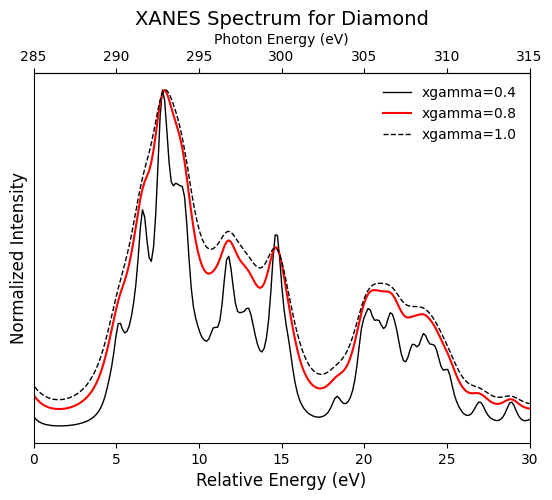

In [ ]:
# compare diamond spectra across different xgamma
rel_energy1, sigma1 = extract_spectra_data("/Users/briannanguyen/Desktop/diamond/diamond_0.4.xspectra.dat")
rel_energy2, sigma2 = extract_spectra_data("/Users/briannanguyen/Desktop/diamond/diamond_0.8.xspectra.dat")
rel_energy3, sigma3 = extract_spectra_data("/Users/briannanguyen/Desktop/diamond/diamond_1.xspectra.dat")

sigma1 = normalize_intensity(sigma1)
sigma2 = normalize_intensity(sigma2)
sigma3 = normalize_intensity(sigma3)

fig, ax1 = plt.subplots()

plt.xlim(0, 30)

ax1.plot(rel_energy1, sigma1, linestyle='-', color = 'k', linewidth=1, label='xgamma=0.4')
ax1.plot(rel_energy2, sigma2, linestyle='-', color='r', label='xgamma=0.8')
ax1.plot(rel_energy3, sigma3, linestyle='--', color = 'k', linewidth=1, label='xgamma=1.0')

ax1.set_xlabel("Relative Energy (eV)", fontsize=12)
ax1.set_ylabel("Normalized Intensity", fontsize=12)
ax1.set_yticks([])
ax1.legend(frameon=False)

ax2 = ax1.secondary_xaxis('top')
ax2.set_xlabel("Photon Energy (eV)")
ticks = [0, 5, 10, 15, 20, 25, 30]
ax2.set_xticks(ticks) 
ax2.set_xticklabels([x + 285 for x in ticks]) 

plt.title("XANES Spectrum for Diamond", fontsize=14)
plt.show()

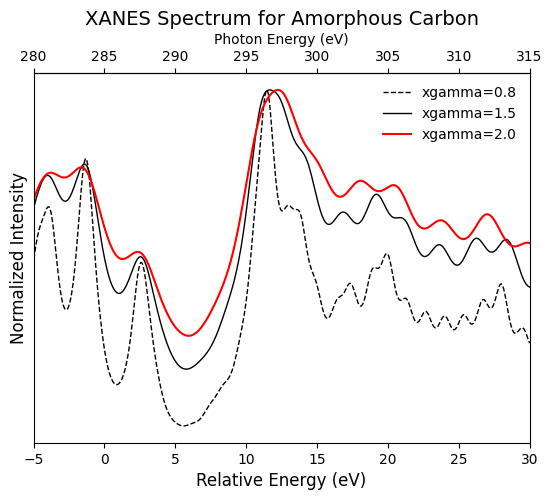

In [292]:
# compare amorphous carbon (core-hole)
rel_energy2, sigma2 = extract_spectra_data("/Users/briannanguyen/Desktop/C20/C20_0.8.xspectra.dat")
rel_energy3, sigma3 = extract_spectra_data("/Users/briannanguyen/Desktop/C20/C20_1.5.xspectra.dat")
rel_energy4, sigma4 = extract_spectra_data("/Users/briannanguyen/Desktop/C20/C20_2.xspectra.dat")
#rel_energy5, sigma5 = extract_spectra_data("/Users/briannanguyen/Desktop/C20_3.xspectra.dat")

sigma1 = normalize_intensity(sigma1)
sigma2 = normalize_intensity(sigma2)
sigma3 = normalize_intensity(sigma3)
sigma4 = normalize_intensity(sigma4)
#sigma5 = normalize_intensity(sigma5)

fig, ax1 = plt.subplots()

plt.xlim(-5, 30)

ax1.plot(rel_energy2, sigma2, linestyle='--', color = 'k', linewidth=1, label='xgamma=0.8')
ax1.plot(rel_energy3, sigma3, linestyle='-', color='k',linewidth=1, label='xgamma=1.5')
ax1.plot(rel_energy4, sigma4, linestyle='-', color='r', label='xgamma=2.0')
#ax1.plot(rel_energy5, sigma5, linestyle='-', color='r', label='xgamma=3.0')

ax1.set_xlabel("Relative Energy (eV)", fontsize=12)
ax1.set_ylabel("Normalized Intensity", fontsize=12)
ax1.set_yticks([])
ax1.legend(frameon=False)

ax2 = ax1.secondary_xaxis('top')
ax2.set_xlabel("Photon Energy (eV)")
ticks = [-5, 0, 5, 10, 15, 20, 25, 30]
ax2.set_xticks(ticks) 
ax2.set_xticklabels([x + 285 for x in ticks]) 

plt.title("XANES Spectrum for Amorphous Carbon", fontsize=14)
plt.show()

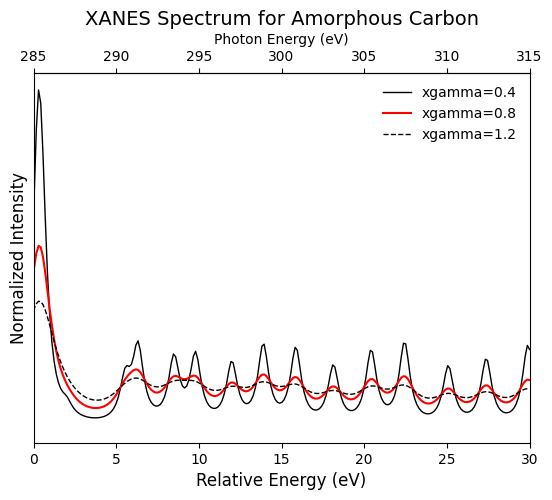

In [ ]:
# compare amorphous carbon spectra across different xgamma (no core-hole)
# need to fix this
rel_energy1, sigma1 = extract_spectra_data("/Users/briannanguyen/Desktop/aC1/aC1_2_0.4.xspectra.dat")
rel_energy2, sigma2 = extract_spectra_data("/Users/briannanguyen/Desktop/aC1/aC1_2_0.8.xspectra.dat")
rel_energy3, sigma3 = extract_spectra_data("/Users/briannanguyen/Desktop/aC1/aC1_2_1.2.xspectra.dat")

fig, ax1 = plt.subplots()
plt.xlim(0, 30)

ax1.plot(rel_energy1, sigma1, linestyle='-', color = 'k', linewidth=1, label='xgamma=0.4')
ax1.plot(rel_energy2, sigma2, linestyle='-', color = 'r', label='xgamma=0.8')
ax1.plot(rel_energy3, sigma3, linestyle='--', color = 'k', linewidth=1, label='xgamma=1.2')

ax1.set_xlabel("Relative Energy (eV)", fontsize=12)
ax1.set_ylabel("Normalized Intensity", fontsize=12)
ax1.set_yticks([])
ax1.legend(frameon=False)
ax2 = ax1.secondary_xaxis('top')
ax2.set_xlabel("Photon Energy (eV)")
ticks = [0, 5, 10, 15, 20, 25, 30]
ax2.set_xticks(ticks) 
ax2.set_xticklabels([x + 285 for x in ticks]) 

plt.title("XANES Spectrum for Amorphous Carbon", fontsize=14)
plt.show()

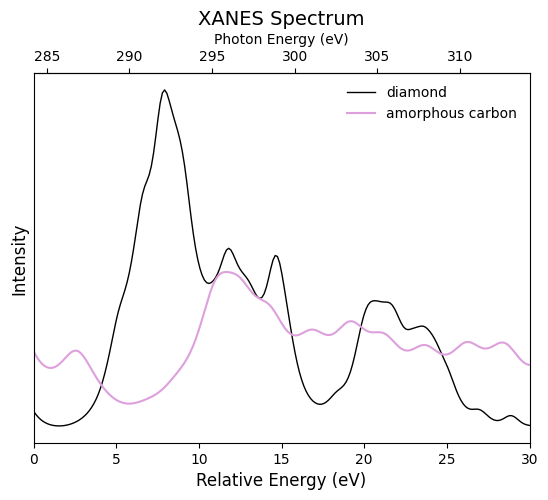

In [298]:
# compare diamond and amorphous carbon spectra
rel_diamond_energy, diamond_sigma = extract_spectra_data("/Users/briannanguyen/Desktop/diamond/diamond_0.8.xspectra.dat")
diamond_energy = [x + 284.2 for x in rel_diamond_energy]
diamond_sigma = diamond_sigma / np.max(diamond_sigma)

rel_energy2, sigma2 = extract_spectra_data("/Users/briannanguyen/Desktop/C20/C20_1.5.xspectra.dat")
energy2 = [x + 284.2 for x in rel_energy2]
sigma2 = sigma2 / (2*np.max(sigma2))

fig, ax1 = plt.subplots()
plt.xlim(0, 30)

ax1.plot(rel_diamond_energy, diamond_sigma, linestyle='-', color = 'k', linewidth=1, label='diamond')
ax1.plot(rel_energy2, sigma2, linestyle='-', color = 'plum', linewidth = 1.5, label='amorphous carbon')

ax1.set_xlabel("Relative Energy (eV)", fontsize=12)
ax1.set_ylabel("Intensity", fontsize=12)
ax1.set_yticks([])
ax1.legend(frameon=False)
ax2 = ax1.secondary_xaxis('top')
ax2.set_xlabel("Photon Energy (eV)")
ticks = [0.8, 5.8, 10.8, 15.8, 20.8, 25.8, 30.8]
ax2.set_xticks(ticks) 
ax2.set_xticklabels([round(x + 284.2) for x in ticks]) 

plt.title("XANES Spectrum", fontsize=14)
plt.show()